In [1]:
from pyecharts import options as opts
from pyecharts.charts import Kline, Line, Bar, Grid, Scatter
from pyecharts.commons.utils import JsCode
from pyecharts.globals import ThemeType

from backtest import *
from technical_analysis import *
from utils import *

import shioaji as sj

In [2]:
# draw line func
def set_global_opts(
    charts,
    title=None,
    filter_mode='filter',
    show_xaxis=True,
    legend_opts={'is_show': False},
    tooltip_position=None,
    always_show_tooltip_content=False,
    toolbox_position=('95%', None),
    y_split_number=5,
    axis_index=None,
    grid_index=None,
    datazoom_position='95%',
    range_=(90, 100),
):
    charts.set_global_opts(
        title_opts=opts.TitleOpts(title=title),
        legend_opts=opts.LegendOpts(
            **legend_opts
        ),
        toolbox_opts=opts.ToolboxOpts(
            orient='vertical',
            pos_left=toolbox_position[0],
            pos_top=toolbox_position[1],
            is_show=True,
            feature=opts.ToolBoxFeatureOpts(
                save_as_image=opts.ToolBoxFeatureSaveAsImageOpts(
                    name=datetime.datetime.now(),
                    title='Download plot as png',
                    type_='png',
                    background_color='white',
                    pixel_ratio=1,
                ),
                restore=opts.ToolBoxFeatureRestoreOpts(
                    title='Restore',
                ),
                data_view=None,
                data_zoom=opts.ToolBoxFeatureDataZoomOpts(
                    zoom_title='Zoom',
                    back_title='Unzoom',
                    xaxis_index=None,
                    yaxis_index=None,
                ),  # 要另外設定DataZoomOpts
                magic_type=None,
                brush=opts.ToolBoxFeatureBrushOpts(
                    rect_title='Box Select',
                    polygon_title='Polygon Select',
                    line_x_title='H Select',
                    line_y_title='V Select',
                    keep_title='Keep Select',
                    clear_title='Clear Select',
                ),  # 要另外設定BrushOpts
            )
        ),
        datazoom_opts=[
            opts.DataZoomOpts(
                is_show=False,
                type_='inside',
                xaxis_index=axis_index,
                range_start=range_[0],
                range_end=range_[1],
                filter_mode=filter_mode,
            ),
            opts.DataZoomOpts(
                is_show=False,
                yaxis_index=None,
                type_='slider',
                orient='vertical',
                range_start=0,
                range_end=100,
                is_zoom_lock=True,
                filter_mode=filter_mode,
            ),
            opts.DataZoomOpts(
                is_show=True,
                xaxis_index=axis_index,
                type_='slider',
                pos_top=datazoom_position,
                range_start=range_[0],
                range_end=range_[1],
                filter_mode=filter_mode,
            ),
        ],
        xaxis_opts=opts.AxisOpts(
            is_show=show_xaxis,
            type_="category",
            is_scale=True,
            grid_index=grid_index,
            min_="dataMin",
            max_="dataMax",
        ),
        yaxis_opts=opts.AxisOpts(
            is_scale=True,
            grid_index=grid_index,
            split_number=y_split_number,
            splitarea_opts=opts.SplitAreaOpts(
                is_show=True, areastyle_opts=opts.AreaStyleOpts(opacity=1)
            ),
            splitline_opts=opts.SplitLineOpts(
                is_show=True, linestyle_opts=opts.LineStyleOpts(
                    width=1, color='#7B7B7B', opacity=0.5
                )
            ),
        ),
        tooltip_opts=opts.TooltipOpts(
            is_always_show_content=always_show_tooltip_content,
            position=tooltip_position,
            trigger_on='mousemove|click',
            trigger='axis',
            axis_pointer_type='line',
            background_color='rgba(245, 245, 245, 0.75)',
            border_width=1,
            border_color='#ccc',
            textstyle_opts=opts.TextStyleOpts(color='#000'),
        ),
        axispointer_opts=opts.AxisPointerOpts(
            is_show=True,
            link=[{'xAxisIndex': 'all'}],  # sharex
            label=opts.LabelOpts(background_color='#777'),
        ),
        brush_opts=opts.BrushOpts(  # 改icon標題要去ToolBoxFeatureBrushOpts改
            tool_box=['rect', 'polygon', 'lineX', 'lineY', 'keep', 'clear'],
            x_axis_index='all',
            brush_link='all',
            out_of_brush={'colorAlpha': 0.1},
            brush_style={
                'color': 'rgba(255, 232, 219, 0.3)',
                'borderColor': 'rgba(133, 44, 0, 0.3)'
            }
        ),
    )


def draw_klines(
    df,
    ma_keys=['sma5', 'sma10', 'sma20', 'sma60'],
    vwap=True,
    bbands=True
):
    xdata = df.index.tolist()
    ydata = np.round(df[['open', 'close', 'low', 'high']].values, 2).tolist()

    # 加資料
    kline = (
        Kline(
            init_opts=opts.InitOpts(
                theme=ThemeType.CHALK,
                bg_color='#23262F',
            )
        )
        .add_xaxis(xdata)
        .add_yaxis(
            series_name='Kline',
            y_axis=ydata,
            itemstyle_opts=opts.ItemStyleOpts(
                color='#FF0000',  # 陽
                color0='#28FF28',  # 陰
                border_color='#FF0000',
                border_color0='#28FF28',
            ),
            markpoint_opts=opts.MarkPointOpts(
                data=[
                    opts.MarkPointItem(value_dim='highest',
                                       type_="max", symbol_size=1),
                    opts.MarkPointItem(value_dim='lowest',
                                       type_="min", symbol_size=1),
                ]
            ),
        )
    )

    line = Line().add_xaxis(xdata)

    if ma_keys is not None:
        mas = np.round(df[ma_keys].values, 2).T.tolist()
        for i, key, in enumerate(ma_keys):
            line.add_yaxis(
                key,
                mas[i],
                is_smooth=True,
                symbol_size=0.1,  # 為了能顯示tooltip又不想顯示symbol
                is_hover_animation=False,
                linestyle_opts=opts.LineStyleOpts(opacity=0.75),
                label_opts=opts.LabelOpts(is_show=False),
            )
    if vwap:
        vwap = np.round(df['vwap'].values, 2).T.tolist()
        line.add_yaxis(
            'vwap',
            vwap,
            is_smooth=True,
            is_selected=False,
            symbol_size=0.1,  # 為了能顯示tooltip又不想顯示symbol
            is_hover_animation=False,
            linestyle_opts=opts.LineStyleOpts(width=2, color='#FFFF37'),
            label_opts=opts.LabelOpts(is_show=False),
        )
    if bbands:
        keys = ['bbands_up', 'bbands_mid', 'bbands_low']
        colors = ['#FFD306', '#00FFFF', '#FFD306']
        bbands_datas = np.round(df[keys].values).T.tolist()
        for i, (key, color) in enumerate(zip(keys, colors)):
            line.add_yaxis(
                key,
                bbands_datas[i],
                is_smooth=True,
                is_selected=False,
                symbol_size=0.1,
                is_hover_animation=False,
                linestyle_opts=opts.LineStyleOpts(width=1.5, color=color),
                label_opts=opts.LabelOpts(is_show=False),
            )
    kline.overlap(line)
    return kline


def draw_volume(
    df,
    ma_keys=['sma5_v', 'sma10_v'],
    grid_index=None,
    category_gap='20%',
):
    xdata = df.index.tolist()
    ydata = df.volume.values.tolist()

    color_func = """
        function(params) {
            var colorList;
            if (sign[params.dataIndex] >= 0) {
                colorList = '#FF0000';
            } else {
                colorList = '#28FF28';
            }
            return colorList;
        }
    """

    bar = (
        Bar(
            init_opts=opts.InitOpts(
                theme=ThemeType.CHALK,
                bg_color='#23262F',
            )
        )
        .add_xaxis(xdata)
        .add_yaxis(
            series_name='Volume',
            y_axis=ydata,
            category_gap=category_gap,
            xaxis_index=grid_index,
            yaxis_index=grid_index,
            label_opts=opts.LabelOpts(is_show=False),
            itemstyle_opts=opts.ItemStyleOpts(
                opacity=0.95, color=JsCode(color_func))
        )
    )

    line = Line().add_xaxis(xdata)
    if ma_keys is not None:
        mas = np.round(df[ma_keys].values, 2).T.tolist()
        for i, key, in enumerate(ma_keys):
            line.add_yaxis(
                key,
                mas[i],
                is_smooth=True,
                symbol_size=0.1,
                is_hover_animation=False,
                linestyle_opts=opts.LineStyleOpts(opacity=1),
                label_opts=opts.LabelOpts(is_show=False),
            )
    bar.overlap(line)

    if grid_index is None:
        sign = np.sign(df.close - df.open).tolist()
        bar.add_js_funcs(f"var sign = {sign}")
    return bar


def draw_indicator(
    df,
    line_keys: Union[list, None] = None,
    bar_key: Union[str, None] = None,
    line_colors: Union[list, None] = None,
    bar_color: Union[str, None] = None,
    arrow_key: Union[str, None] = None,
    arrow_colors: Union[tuple, None] = ['#28FF28', '#FF0000'],
    arrow_size=10,
    round_=2,
    category_gap='20%',
    grid_index=None,
):
    xdata = df.index.tolist()

    color_func = """
        function(params) {
            var colorList;
            if (params.data >= 0) {
                colorList = '#FF0000';
            } else {
                colorList = '#28FF28';
            }
            return colorList;
        }
    """
    bar = (
        Bar(
            init_opts=opts.InitOpts(
                theme=ThemeType.CHALK,
                bg_color='#23262F',
            )
        )
        .add_xaxis(xdata)
    )
    if bar_key is not None:
        ydata = np.round(df[bar_key].values, round_).tolist()
        if bar_color is None:
            bar_color = JsCode(color_func)

        bar.add_yaxis(
            series_name=bar_key,
            y_axis=ydata,
            category_gap=category_gap,
            xaxis_index=grid_index,
            yaxis_index=grid_index,
            label_opts=opts.LabelOpts(is_show=False),
            itemstyle_opts=opts.ItemStyleOpts(opacity=0.95, color=bar_color)
        )

    line = Line().add_xaxis(xdata)
    if line_keys is not None:
        ydatas = np.round(df[line_keys].values, round_).T.tolist()
        if line_colors is None:
            colors = [None for i in range(len(line_keys))]
        for i, key, in enumerate(line_keys):
            line.add_yaxis(
                key,
                ydatas[i],
                is_smooth=True,
                symbol_size=0.1,
                is_hover_animation=False,
                linestyle_opts=opts.LineStyleOpts(color=colors[i]),
                label_opts=opts.LabelOpts(is_show=False),
            )

    scatter = Scatter().add_xaxis(xdata)
    if arrow_key is not None:
        color_map = {1: 1, -1: 0, 0: 0}
        ydata = np.round(
            df[[arrow_key, line_keys[0]]].replace(
                {'death': -1, 'gold': 1}).values,
            round_).tolist()
        scatteritems = [
            opts.ScatterItem(
                name='',
                value=-v[0]*2+v[1],
                symbol='arrow',
                symbol_rotate=90-90*v[0],
                symbol_size=arrow_size,
                itemstyle_opts=opts.ItemStyleOpts(
                    color=arrow_colors[
                        color_map[color_map[np.nan_to_num(v[0])]]
                    ]
                ),
            ) for v in ydata
        ]

        scatter.add_yaxis(
            series_name='cross',
            y_axis=scatteritems,
            xaxis_index=grid_index,
            yaxis_index=grid_index,
            label_opts=opts.LabelOpts(is_show=False),
            itemstyle_opts=opts.ItemStyleOpts(opacity=0.95),
        )
        scatter.set_series_opts(tooltip_opts=opts.TooltipOpts(is_show=False))

    bar.overlap(line)
    bar.overlap(scatter)
    return bar

In [3]:
# init
api = sj.Shioaji(simulation=True)
api.login(
    'PAPIUSER01', '2222'
);

# contract
contract = api.Contracts.Futures.TXF.TXF202112

Response Code: 0 | Event Code: 0 | Info: host '218.32.76.102:80', hostname '218.32.76.102:80' IP 218.32.76.102:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


In [8]:
ticks = api.ticks(
    contract=contract,
    date='2021-12-10',
)
#ticks = collate_ticks(ticks)
ticks = collate_ticks(ticks).between_time('08:45', '13:45')
#ticks = collate_ticks(ticks).between_time('15:00', '05:00')
df = ticks2kbar(ticks, rule='1min', with_tick_info=True)
df

open     high      low    close  volume  buy_v  buy_c  \
date                                                                            
2021-12-10 08:46:00  17808.0  17827.0  17792.0  17818.0    2376   1284    509   
2021-12-10 08:47:00  17818.0  17837.0  17812.0  17833.0     634    325    149   
2021-12-10 08:48:00  17832.0  17835.0  17829.0  17834.0     287    152     77   
2021-12-10 08:49:00  17833.0  17834.0  17827.0  17828.0     262     88     43   
2021-12-10 08:50:00  17828.0  17829.0  17824.0  17829.0     191     81     42   
...                      ...      ...      ...      ...     ...    ...    ...   
2021-12-10 13:41:00  17820.0  17821.0  17818.0  17818.0     276    156     52   
2021-12-10 13:42:00  17818.0  17818.0  17812.0  17814.0     254     94     50   
2021-12-10 13:43:00  17812.0  17817.0  17811.0  17816.0     362    165     68   
2021-12-10 13:44:00  17814.0  17817.0  17813.0  17815.0     344    193     71   
2021-12-10 13:45:00  17815.0  17820.0  17814.0  17818.0     742    425    123   

                        buy_m  sell_v  sell_c    sell_m  v_diff  c_diff  \
date                                                                      
2021-12-10 08:46:00  2.522593    1044     563  1.854352     240     -54   
2021-12-10 08:47:00  2.181208     298     173  1.722543      27     -24   
2021-12-10 08:48:00  1.974026     129      72  1.791667      23       5   
2021-12-10 08:49:00  2.046512     174      76  2.289474     -86     -33   
2021-12-10 08:50:00  1.928571     108      57  1.894737     -27     -15   
...                       ...     ...     ...       ...     ...     ...   
2021-12-10 13:41:00  3.000000     114      58  1.965517      42      -6   
2021-12-10 13:42:00  1.880000     159      61  2.606557     -65     -11   
2021-12-10 13:43:00  2.426471     197      71  2.774648     -32      -3   
2021-12-10 13:44:00  2.718310     145      58  2.500000      48      13   
2021-12-10 13:45:00  3.455285     315     143  2.202797     110     -20   

                       m_diff  v_diff_cum  c_diff_cum  m_diff_cum  
date                                                               
2021-12-10 08:46:00  0.668242         240         -54    0.668242  
2021-12-10 08:47:00  0.458665         267         -78    1.126906  
2021-12-10 08:48:00  0.182359         290         -73    1.309266  
2021-12-10 08:49:00 -0.242962         204        -106    1.066304  
2021-12-10 08:50:00  0.033835         177        -121    1.100138  
...                       ...         ...         ...         ...  
2021-12-10 13:41:00  1.034483        -120          30  -22.113440  
2021-12-10 13:42:00 -0.726557        -185          19  -22.839997  
2021-12-10 13:43:00 -0.348177        -217          16  -23.188175  
2021-12-10 13:44:00  0.218310        -169          29  -22.969865  
2021-12-10 13:45:00  1.252487         -59           9  -21.717378  

[297 rows x 17 columns]

In [9]:
df = (
    df
    .pipe(cal_sma, 'close', (5, 10, 20, 60, 120))
    .pipe(cal_sma, 'volume', (5, 10), suffix='_v')
    .pipe(cal_bbands)
    .pipe(cal_vwap, '5H')
    .pipe(cal_macd)
    .pipe(cal_kdj)
    .pipe(cal_kd_cross)
)
df

open     high      low    close  volume  buy_v  buy_c  \
date                                                                            
2021-12-10 08:46:00  17808.0  17827.0  17792.0  17818.0    2376   1284    509   
2021-12-10 08:47:00  17818.0  17837.0  17812.0  17833.0     634    325    149   
2021-12-10 08:48:00  17832.0  17835.0  17829.0  17834.0     287    152     77   
2021-12-10 08:49:00  17833.0  17834.0  17827.0  17828.0     262     88     43   
2021-12-10 08:50:00  17828.0  17829.0  17824.0  17829.0     191     81     42   
...                      ...      ...      ...      ...     ...    ...    ...   
2021-12-10 13:41:00  17820.0  17821.0  17818.0  17818.0     276    156     52   
2021-12-10 13:42:00  17818.0  17818.0  17812.0  17814.0     254     94     50   
2021-12-10 13:43:00  17812.0  17817.0  17811.0  17816.0     362    165     68   
2021-12-10 13:44:00  17814.0  17817.0  17813.0  17815.0     344    193     71   
2021-12-10 13:45:00  17815.0  17820.0  17814.0  17818.0     742    425    123   

                        buy_m  sell_v  sell_c  ...  bbands_percent  bbands_bw  \
date                                           ...                              
2021-12-10 08:46:00  2.522593    1044     563  ...             NaN        NaN   
2021-12-10 08:47:00  2.181208     298     173  ...             NaN        NaN   
2021-12-10 08:48:00  1.974026     129      72  ...             NaN        NaN   
2021-12-10 08:49:00  2.046512     174      76  ...             NaN        NaN   
2021-12-10 08:50:00  1.928571     108      57  ...             NaN        NaN   
...                       ...     ...     ...  ...             ...        ...   
2021-12-10 13:41:00  3.000000     114      58  ...        0.247497   0.002832   
2021-12-10 13:42:00  1.880000     159      61  ...        0.180902   0.002558   
2021-12-10 13:43:00  2.426471     197      71  ...        0.242513   0.002364   
2021-12-10 13:44:00  2.718310     145      58  ...        0.236123   0.002179   
2021-12-10 13:45:00  3.455285     315     143  ...        0.328054   0.001909   

                             vwap  macd_dif  macd_dem  macd_osc          k  \
date                                                                         
2021-12-10 08:46:00  17806.000000       NaN       NaN       NaN        NaN   
2021-12-10 08:47:00  17809.159468       NaN       NaN       NaN        NaN   
2021-12-10 08:48:00  17811.118694       NaN       NaN       NaN        NaN   
2021-12-10 08:49:00  17812.459586       NaN       NaN       NaN        NaN   
2021-12-10 08:50:00  17813.200178       NaN       NaN       NaN        NaN   
...                           ...       ...       ...       ...        ...   
2021-12-10 13:41:00  17837.005386 -8.190138 -6.939470 -1.250668  31.818182   
2021-12-10 13:42:00  17836.394618 -8.319491 -7.215474 -1.104017  15.000000   
2021-12-10 13:43:00  17835.517199 -8.166482 -7.405676 -0.760807  35.714286   
2021-12-10 13:44:00  17834.776711 -8.033311 -7.531203 -0.502108  33.333333   
2021-12-10 13:45:00  17833.456199 -7.598110 -7.544584 -0.053526  70.000000   

                             d           j  kd_cross  
date                                                  
2021-12-10 08:46:00        NaN         NaN       NaN  
2021-12-10 08:47:00        NaN         NaN       NaN  
2021-12-10 08:48:00        NaN         NaN       NaN  
2021-12-10 08:49:00        NaN         NaN       NaN  
2021-12-10 08:50:00        NaN         NaN       NaN  
...                        ...         ...       ...  
2021-12-10 13:41:00  22.502926   50.448694       NaN  
2021-12-10 13:42:00  20.001951    4.996099     death  
2021-12-10 13:43:00  25.239396   56.664066      gold  
2021-12-10 13:44:00  27.937375   44.125250       NaN  
2021-12-10 13:45:00  41.958250  126.083500       NaN  

[297 rows x 37 columns]

# one plate

In [6]:
# first
kline = draw_klines(df)
set_global_opts(
    kline,
    axis_index=[0],
    grid_index=0,
    show_xaxis=True,
    title='2330',
    legend_opts={'is_show': True, 'pos_top': '0%'},
    toolbox_position=('0.5%', '7%'),
    tooltip_position=('85%', '7%'),
    range_=(60, 100),
)

grid = (
    Grid(
        init_opts=opts.InitOpts(
            width='1000px',
            height='800px',
            theme=ThemeType.CHALK,
            bg_color="#23262F",
        )
    )
    .add(kline, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", height="85%"))

)
grid.render_notebook()

# two plate

In [7]:
# first
kline = draw_klines(df)
set_global_opts(
    kline,
    axis_index=[0, 1],
    grid_index=0,
    show_xaxis=False,
    title='2330',
    legend_opts={'is_show': True, 'pos_top': '0%'},
    toolbox_position=('0.5%', '7%'),
    tooltip_position=('85%', '7%'),
    range_=(60, 100),
)
bar = draw_volume(df, category_gap='1%')
set_global_opts(
    bar,
    y_split_number=2,
    legend_opts={'is_show': True, 'pos_top': '5%'},
)

grid = (
    Grid(
        init_opts=opts.InitOpts(
            width='1000px',
            height='800px',
            theme=ThemeType.CHALK,
            bg_color="#23262F",
        )
    )
    .add(kline, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", height="60%"))
    .add(bar, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="70%", height="16%"))

)
sign = np.sign(df.close - df.open).tolist()
grid.add_js_funcs(f"var sign = {sign}")
grid.render_notebook()

# three plate

In [8]:
# first
kline = draw_klines(df)
set_global_opts(
    kline,
    y_split_number=5,
    axis_index=[0, 1, 2],
    show_xaxis=False,
    title='TXFR1',
    legend_opts={'is_show': True, 'pos_top': '0%', 'pos_left': '9%'},
    toolbox_position=('0.5%', '7%'),
    tooltip_position=('86%', '7%'),
    always_show_tooltip_content=True,
    range_=(60, 100),
    datazoom_position='98%',
)

# second
bar = draw_volume(df, category_gap='1%')
set_global_opts(
    bar,
    show_xaxis=False,
    y_split_number=2,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '9%'},
)

# third
indicator1 = draw_indicator(df, ['k', 'd', 'j'], arrow_key='kd_cross')
set_global_opts(
    indicator1,
    y_split_number=2,
    show_xaxis=True,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '35%'},
)

grid = (
    Grid(
        init_opts=opts.InitOpts(
            width='1100px',
            height='800px',
            theme=ThemeType.CHALK,
            bg_color="#23262F",
        )
    )
    .add(kline, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="6%", height="50%"))
    .add(bar, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="60%", height="15%"))
    .add(indicator1, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="75%", height="20%"))
)
sign = np.sign(df.close - df.open).tolist()
grid.add_js_funcs(f"var sign = {sign}")
grid.page_title = 'test'
grid.render_notebook()

# four plate

In [25]:
# first
kline = draw_klines(df)
set_global_opts(
    kline,
    y_split_number=5,
    axis_index=[0, 1, 2, 3],
    show_xaxis=False,
    title='TXFR1',
    legend_opts={'is_show': True, 'pos_top': '0%', 'pos_left': '9%'},
    toolbox_position=('0.5%', '7%'),
    tooltip_position=('86%', '7%'),
    always_show_tooltip_content=True,
    range_=(60, 100),
    datazoom_position='98%',
)

# second
bar = draw_volume(df, category_gap='1%')
set_global_opts(
    bar,
    show_xaxis=False,
    y_split_number=2,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '9%'},
)

# third
indicator1 = draw_indicator(df, ['k', 'd', 'j'], arrow_key='kd_cross')
set_global_opts(
    indicator1,
    y_split_number=2,
    show_xaxis=False,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '35%'},
)
indicator2 = draw_indicator(
    df, ['macd_dif', 'macd_dem'], 'macd_osc', category_gap=0)
set_global_opts(
    indicator2,
    y_split_number=2,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '60%'},
)

grid = (
    Grid(
        init_opts=opts.InitOpts(
            width='1100px',
            height='800px',
            theme=ThemeType.CHALK,
            bg_color="#23262F",
        )
    )
    .add(kline, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="6%", height="35%"))
    .add(bar, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="43%", height="12%"))
    .add(indicator1, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="57.5%", height="18%"))
    .add(indicator2, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="77%", height="18%"))
)
sign = np.sign(df.close - df.open).tolist()
grid.add_js_funcs(f"var sign = {sign}")
grid.page_title = 'test'
grid.render_notebook()

In [26]:
# first
kline = draw_klines(df)
set_global_opts(
    kline,
    y_split_number=5,
    axis_index=[0, 1, 2, 3],
    show_xaxis=False,
    title='TXFR1',
    legend_opts={'is_show': True, 'pos_top': '0%', 'pos_left': '9%'},
    toolbox_position=('0.5%', '7%'),
    tooltip_position=('86%', '7%'),
    always_show_tooltip_content=True,
    range_=(0, 100),
    datazoom_position='98%',
)

# second
bar = draw_volume(df, category_gap='1%')
set_global_opts(
    bar,
    show_xaxis=False,
    y_split_number=2,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '9%'},
)

# third
indicator1 = draw_indicator(df, ['k', 'd', 'j'], arrow_key='kd_cross')
set_global_opts(
    indicator1,
    y_split_number=2,
    show_xaxis=False,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '35%'},
)
indicator2 = draw_indicator(
    df, ['v_diff'], 'v_diff_cum', category_gap='0%')
set_global_opts(
    indicator2,
    y_split_number=4,
    show_xaxis=False,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '60%'},
)

grid = (
    Grid(
        init_opts=opts.InitOpts(
            width='1100px',
            height='800px',
            theme=ThemeType.CHALK,
            bg_color="#23262F",
        )
    )
    .add(kline, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="6%", height="35%"))
    .add(bar, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="43%", height="12%"))
    .add(indicator1, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="57.5%", height="18%"))
    .add(indicator2, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="77%", height="18%"))
)
sign = np.sign(df.close - df.open).tolist()
grid.add_js_funcs(f"var sign = {sign}")
grid.page_title = 'test'
grid.render_notebook()

In [27]:
def draw_volume2(
    df,
    yaxis_index=None,
    category_gap='5%',
):
    
    xdata = df.index.tolist()
    
    sign = np.sign(df.close - df.open)
    volume = df.volume.astype(float)
    volume[0] = np.nan
    volume_cum = (volume * sign).cumsum().tolist()
    volume = volume * sign.replace({0:1})

    color_func = """
        function(params) {
            var colorList;
            if (params.data >= 0) {
                colorList = '#FF0000';
            } else {
                colorList = '#28FF28';
            }
            return colorList;
        }
    """

    bar = (
        Bar(
            init_opts=opts.InitOpts(
                theme=ThemeType.CHALK,
                bg_color='#23262F',
            )
        )
        .add_xaxis(xdata)
        .add_yaxis(
            series_name='Volume',
            y_axis=volume,
            category_gap=category_gap,
            label_opts=opts.LabelOpts(is_show=False),
            itemstyle_opts=opts.ItemStyleOpts(opacity=0.95, color=JsCode(color_func))
        )
    )

    line = Line().add_xaxis(xdata)
    line.add_yaxis(
        '多空差值',
        volume_cum,
        is_smooth=True,
        symbol_size=0.1,
        is_hover_animation=False,
        linestyle_opts=opts.LineStyleOpts(opacity=1, color='#CAFFFF'),
        label_opts=opts.LabelOpts(is_show=False),
    )

    
    bar.overlap(line)
    return bar

In [28]:
# first
kline = draw_klines(df)
set_global_opts(
    kline,
    y_split_number=5,
    axis_index=[0, 1, 2, 3],
    show_xaxis=False,
    title='TXFR1',
    legend_opts={'is_show': True, 'pos_top': '0%', 'pos_left': '9%'},
    toolbox_position=('0.5%', '7%'),
    tooltip_position=('86%', '7%'),
    always_show_tooltip_content=True,
    range_=(0, 100),
    datazoom_position='98%',
)

# second
#bar = draw_volume(df, category_gap='1%')
df['sell_v_cum'] = df.sell_v.cumsum()
df['buy_v_cum'] = df.buy_v.cumsum()
df['buy_v/sell_v'] = df['buy_v_cum'] / (df['sell_v_cum'] + df['buy_v_cum'])
bar = draw_indicator(df, ['buy_v/sell_v'], round_=6)
set_global_opts(
    bar,
    show_xaxis=False,
    y_split_number=2,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '9%'},
)

# third
indicator1 = draw_volume2(df)
set_global_opts(
    indicator1,
    y_split_number=2,
    show_xaxis=False,
    grid_index=4,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '35%'},
)
indicator2 = draw_indicator(df, ['v_diff'], 'v_diff_cum', category_gap='0%')
set_global_opts(
    indicator2,
    y_split_number=4,
    show_xaxis=False,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '60%'},
)

grid = (
    Grid(
        init_opts=opts.InitOpts(
            width='1100px',
            height='800px',
            theme=ThemeType.CHALK,
            bg_color="#23262F",
        )
    )
    .add(kline, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="6%", height="35%"))
    .add(bar, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="43%", height="12%"))
    .add(indicator1, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="57.5%", height="18%"))
    .add(indicator2, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="77%", height="18%"))
)
sign = np.sign(df.close - df.open).tolist()
grid.add_js_funcs(f"var sign = {sign}")
grid.page_title = 'test'
grid.render_notebook()

# five plate

In [29]:
# first
kline = draw_klines(df)
set_global_opts(
    kline,
    y_split_number=5,
    axis_index=[0, 1, 2, 3, 4],
    show_xaxis=False,
    title='TXFR1',
    legend_opts={'is_show': True, 'pos_top': '0%', 'pos_left': '9%'},
    toolbox_position=('0.5%', '7%'),
    tooltip_position=('86%', '7%'),
    always_show_tooltip_content=True,
    range_=(0, 100),
    datazoom_position='98%',
)

# second
bar = draw_volume(df, category_gap='1%')
set_global_opts(
    bar,
    show_xaxis=False,
    y_split_number=2,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '9%'},
)

# third
indicator1 = draw_indicator(
    df, ['c_diff'], 'c_diff_cum', category_gap='0%')
set_global_opts(
    indicator1,
    y_split_number=2,
    show_xaxis=False,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '35%'},
)
# 4th
indicator2 = draw_indicator(
    df, ['v_diff'], 'v_diff_cum', category_gap='0%')
set_global_opts(
    indicator2,
    y_split_number=4,
    show_xaxis=False,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '60%'},
)
# 5th
indicator3 = draw_indicator(
    df, ['m_diff'], 'm_diff_cum', category_gap='0%')
set_global_opts(
    indicator3,
    y_split_number=4,
    show_xaxis=True,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '80%'},
)

grid = (
    Grid(
        init_opts=opts.InitOpts(
            width='1100px',
            height='800px',
            theme=ThemeType.CHALK,
            bg_color="#23262F",
        )
    )
    .add(kline, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="6%", height="25%"))
    .add(bar, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="33%", height="12%"))
    .add(indicator1, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="45%", height="16.5%"))
    .add(indicator2, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="64%", height="16.5%"))
    .add(indicator3, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="83%", height="16.5%"))
)
sign = np.sign(df.close - df.open).tolist()
grid.add_js_funcs(f"var sign = {sign}")
grid.page_title = 'test'
grid.render_notebook()


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (00004ce0) Session '(c1,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/PAPIUSER01/1210/143508/898340/1.34.144.108', VPN name 'sinopac', peer address 'hostname '218.32.76.102:80' IP 218.32 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '218.32.76.102:80', hostname '218.32.76.102:80' IP 218.32.76.102:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 3) | Event: Session reconnected


In [170]:
# first
kline = draw_klines(df, ma_keys=['sma5', 'sma10', 'sma20', 'sma60', 'sma120'],)
set_global_opts(
    kline,
    y_split_number=5,
    axis_index=[0, 1, 2, 3, 4],
    show_xaxis=False,
    title='TXFR1',
    legend_opts={'is_show': True, 'pos_top': '0%', 'pos_left': '9%'},
    toolbox_position=('0.5%', '7%'),
    tooltip_position=('86%', '7%'),
    always_show_tooltip_content=True,
    range_=(0, 100),
    datazoom_position='98%',
)

# second
plate2 = draw_volume2(df)
set_global_opts(
    plate2,
    show_xaxis=False,
    y_split_number=4,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '9%'},
)

# third
df['sell_v_cum'] = df.sell_v.cumsum()
df['buy_v_cum'] = df.buy_v.cumsum()
df['buy_v/sell_v'] = df['buy_v_cum'] / (df['sell_v_cum'] + df['buy_v_cum'])
plate3 = draw_indicator(df, ['buy_v/sell_v'], round_=6)
set_global_opts(
    plate3,
    y_split_number=4,
    show_xaxis=False,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '35%'},
)
# 4th
plate4 = draw_indicator(df, ['v_diff'], 'v_diff_cum', category_gap='0%')
set_global_opts(
    plate4,
    y_split_number=4,
    show_xaxis=False,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '60%'},
)

# 5th
df['盤差'] = df['buy_v_cum'] - df['sell_v_cum']
plate5 = draw_indicator(df, bar_key='盤差', category_gap='0%')
set_global_opts(
    plate5,
    y_split_number=4,
    show_xaxis=True,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '80%'},
)

grid = (
    Grid(
        init_opts=opts.InitOpts(
            width='1100px',
            height='800px',
            theme=ThemeType.CHALK,
            bg_color="#23262F",
        )
    )
    .add(kline, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="6%", height="25%"))
    .add(plate2, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="33%", height="12%"))
    .add(plate3, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="47%", height="16.5%"))
    .add(plate4, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="65%", height="16.5%"))
    .add(plate5, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="83%", height="16.5%"))
)
sign = np.sign(df.close - df.open).tolist()
grid.add_js_funcs(f"var sign = {sign}")
grid.page_title = 'test'
grid.render_notebook()

In [470]:
from sklearn.linear_model import Ridge

In [471]:
y = df.close.diff()[1:]
x = df.v_diff_cum.diff()[1:, None]
np.corrcoef(x[:, 0], y)

array([[1.        , 0.71667538],
       [0.71667538, 1.        ]])

In [472]:
m = Ridge().fit(x, y)
m.score(x, y), m.coef_, m.intercept_

(0.5136236003628547, array([0.02920349]), 0.0968456076757334)

In [565]:
preds = m.coef_ * x.squeeze() + m.intercept_

_abs = abs(preds - y)
margin = _abs.quantile(0.95)
index = _abs > margin
{q: _abs.quantile(q/100) for q in (0, 5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95, 100)}

{0: 0.0012751909818655704,
 5: 0.07001595154820178,
 10: 0.15525259666995733,
 15: 0.26067751338780354,
 20: 0.4358984803704753,
 25: 0.640322941850259,
 50: 1.2013232409828563,
 75: 2.1844560911670694,
 80: 2.5669339944688025,
 85: 3.098659841755497,
 90: 3.87890772879589,
 95: 5.054540834029865,
 100: 21.786203339723052}

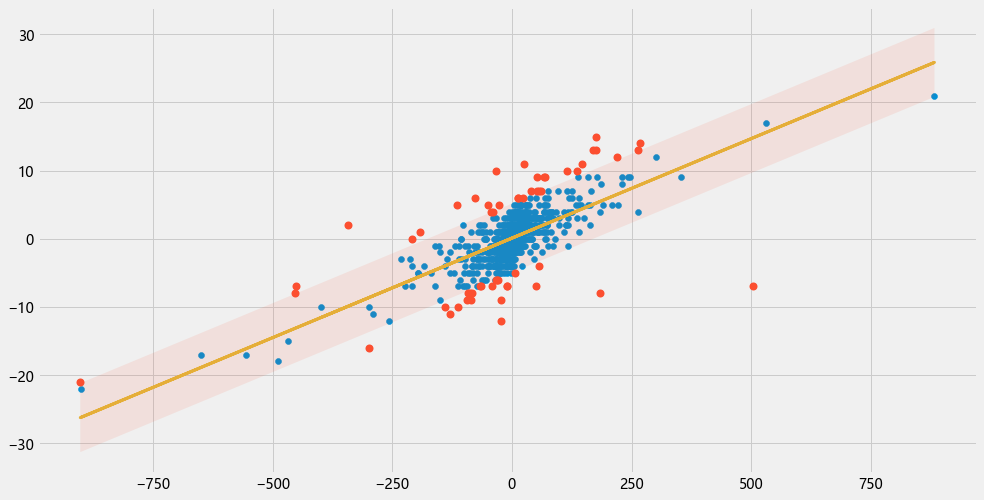

In [566]:
plt.plot(x, preds, color='C2')
plt.scatter(x, y)
plt.scatter(x[index], y[index], color='C1', linewidths=2)


ci_x = np.linspace(x.min(), x.max(), len(x))
ci_y = m.coef_ * ci_x + m.intercept_
plt.fill_between(ci_x, ci_y-_abs.quantile(0.95),ci_y+_abs.quantile(0.95), alpha=0.1)

In [442]:
# first
kline = draw_klines(df)

##############################
_index = pd.Series(index, index=df.index).fillna(False)
colors = pd.Series(np.sign(y[index] - preds[index]), index=df.index).replace({-1:'yellow', 1:'red'})
scatter = Scatter().add_xaxis(df.index.tolist())
scatteritems = [
    opts.ScatterItem(
        name='',
        value=v+1,
        symbol='pin',
        symbol_size=15,
        itemstyle_opts=opts.ItemStyleOpts(opacity=1, color=color),
        )
     for v, color in zip(df.high.where(_index), colors)
]
scatter.add_yaxis(
    series_name='',
    y_axis=scatteritems,
    label_opts=opts.LabelOpts(is_show=False),
)
scatter.set_series_opts(tooltip_opts=opts.TooltipOpts(is_show=False))
kline.overlap(scatter)
#####################################
set_global_opts(
    kline,
    y_split_number=5,
    axis_index=[0, 1, 2, 3],
    show_xaxis=False,
    title='TXFR1',
    legend_opts={'is_show': True, 'pos_top': '0%', 'pos_left': '9%'},
    toolbox_position=('0.5%', '7%'),
    tooltip_position=('86%', '7%'),
    always_show_tooltip_content=True,
    range_=(0, 100),
    datazoom_position='98%',
)

# second
#bar = draw_volume(df, category_gap='1%')
df['sell_v_cum'] = df.sell_v.cumsum()
df['buy_v_cum'] = df.buy_v.cumsum()
df['buy_v/sell_v'] = df['buy_v_cum'] / (df['sell_v_cum'] + df['buy_v_cum'])
bar = draw_indicator(df, ['buy_v/sell_v'], round_=6)
set_global_opts(
    bar,
    show_xaxis=False,
    y_split_number=2,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '9%'},
)

# third
indicator1 = draw_volume2(df)
set_global_opts(
    indicator1,
    y_split_number=2,
    show_xaxis=False,
    grid_index=4,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '35%'},
)
indicator2 = draw_indicator(df, ['v_diff'], 'v_diff_cum', category_gap='0%')
set_global_opts(
    indicator2,
    y_split_number=4,
    show_xaxis=False,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '60%'},
)

grid = (
    Grid(
        init_opts=opts.InitOpts(
            width='1100px',
            height='800px',
            theme=ThemeType.CHALK,
            bg_color="#23262F",
        )
    )
    .add(kline, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="6%", height="35%"))
    .add(bar, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="43%", height="12%"))
    .add(indicator1, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="57.5%", height="18%"))
    .add(indicator2, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="77%", height="18%"))
)
sign = np.sign(df.close - df.open).tolist()
grid.add_js_funcs(f"var sign = {sign}")
grid.page_title = 'test'
grid.render_notebook()

In [217]:
x = np.array([df.volume, df.volume.diff(), df.v_diff_cum, df.v_diff_cum.diff()]).T
corr = pd.DataFrame([*x.T, y]).T.corr()
items = ['成交量', '成交量變化', '盤差', '盤差變化', '價格變化']
corr.index = items
corr.columns = items
corr

成交量     成交量變化        盤差      盤差變化      價格變化
成交量    1.000000  0.465790  0.232249 -0.272310 -0.196866
成交量變化  0.465790  1.000000 -0.040124 -0.225612 -0.127333
盤差     0.232249 -0.040124  1.000000  0.107676  0.027322
盤差變化  -0.272310 -0.225612  0.107676  1.000000  0.758322
價格變化  -0.196866 -0.127333  0.027322  0.758322  1.000000

In [451]:
df5 = ticks2kbar(ticks, '5min', diff=True)
df5 = (
    df5
    .pipe(cal_sma, 'close', (5, 10, 20, 60, 120))
    .pipe(cal_sma, 'volume', (5, 10), suffix='_v')
    .pipe(cal_bbands)
    .pipe(cal_vwap, '5H')
    .pipe(cal_macd)
    .pipe(cal_kdj)
    .pipe(cal_kd_cross)
)

In [452]:
# first
kline = draw_klines(df5)
set_global_opts(
    kline,
    y_split_number=5,
    axis_index=[0, 1, 2, 3],
    show_xaxis=False,
    title='TXFR1',
    legend_opts={'is_show': True, 'pos_top': '0%', 'pos_left': '9%'},
    toolbox_position=('0.5%', '7%'),
    tooltip_position=('86%', '7%'),
    always_show_tooltip_content=True,
    range_=(0, 100),
    datazoom_position='98%',
)

# second
#bar = draw_volume(df5, category_gap='1%')
df5['sell_v_cum'] = df5.sell_v.cumsum()
df5['buy_v_cum'] = df5.buy_v.cumsum()
df5['buy_v/sell_v'] = df5['buy_v_cum'] / (df5['sell_v_cum'] + df5['buy_v_cum'])
bar = draw_indicator(df5, ['buy_v/sell_v'], round_=6)
set_global_opts(
    bar,
    show_xaxis=False,
    y_split_number=2,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '9%'},
)

# third
indicator1 = draw_volume2(df5)
set_global_opts(
    indicator1,
    y_split_number=2,
    show_xaxis=False,
    grid_index=4,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '35%'},
)
indicator2 = draw_indicator(df5, ['v_diff'], 'v_diff_cum', category_gap='0%')
set_global_opts(
    indicator2,
    y_split_number=4,
    show_xaxis=False,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '60%'},
)

grid = (
    Grid(
        init_opts=opts.InitOpts(
            width='1100px',
            height='800px',
            theme=ThemeType.CHALK,
            bg_color="#23262F",
        )
    )
    .add(kline, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="6%", height="35%"))
    .add(bar, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="43%", height="12%"))
    .add(indicator1, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="57.5%", height="18%"))
    .add(indicator2, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="77%", height="18%"))
)
sign = np.sign(df5.close - df5.open).tolist()
grid.add_js_funcs(f"var sign = {sign}")
grid.page_title = 'test'
grid.render_notebook()

In [453]:
y = df5.close.diff()[1:]
x = df5.v_diff_cum.diff()[1:, None]
np.corrcoef(x[:, 0], y)

array([[1.        , 0.83848301],
       [0.83848301, 1.        ]])

In [454]:
m = Ridge().fit(x, y)
m.score(x, y), m.coef_, m.intercept_

(0.7030537510920228, array([0.02379908]), 1.0847732457520654)

In [455]:
preds = m.predict(x)

_abs = abs(preds - y)
margin = _abs.quantile(0.95)
index = _abs > margin
{q: _abs.quantile(q/100) for q in (0, 5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95, 100)}

{0: 0.3981107929350136,
 5: 0.837368399361928,
 10: 0.9045146515957577,
 15: 1.2617640844211442,
 20: 1.5895605300750633,
 25: 1.9864045593646726,
 50: 3.9632637457200386,
 75: 7.048475832517813,
 80: 7.9394810853310585,
 85: 8.87678135191466,
 90: 10.314321370770106,
 95: 12.45120033181992,
 100: 20.25136677224445}

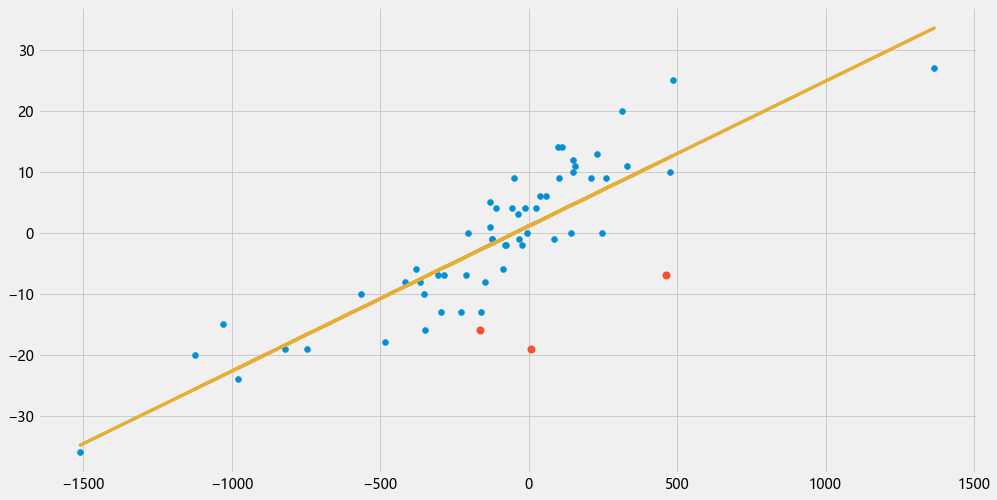

In [456]:
#plt.plot(x, preds, color='C1')
plt.plot(x, 0.02379908 * x + 1.0847732457520654, color='C2')
plt.scatter(x, y)
plt.scatter(x[index], y[index], color='C1', linewidths=2)

In [457]:
# first
kline = draw_klines(df5)

##############################
_index = pd.Series(index, index=df5.index).fillna(False)
colors = pd.Series(np.sign(y[index] - preds[index]), index=df5.index).replace({-1:'yellow', 1:'red'})
scatter = Scatter().add_xaxis(df5.index.tolist())
scatteritems = [
    opts.ScatterItem(
        name='',
        value=v+1,
        symbol='pin',
        symbol_size=15,
        itemstyle_opts=opts.ItemStyleOpts(opacity=1, color=color),
        )
     for v, color in zip(df5.high.where(_index), colors)
]
scatter.add_yaxis(
    series_name='',
    y_axis=scatteritems,
    label_opts=opts.LabelOpts(is_show=False),
)
scatter.set_series_opts(tooltip_opts=opts.TooltipOpts(is_show=False))
kline.overlap(scatter)
#####################################
set_global_opts(
    kline,
    y_split_number=5,
    axis_index=[0, 1, 2, 3],
    show_xaxis=False,
    title='TXFR1',
    legend_opts={'is_show': True, 'pos_top': '0%', 'pos_left': '9%'},
    toolbox_position=('0.5%', '7%'),
    tooltip_position=('86%', '7%'),
    always_show_tooltip_content=True,
    range_=(0, 100),
    datazoom_position='98%',
)

# second
#bar = draw_volume(df5, category_gap='1%')
df5['sell_v_cum'] = df5.sell_v.cumsum()
df5['buy_v_cum'] = df5.buy_v.cumsum()
df5['buy_v/sell_v'] = df5['buy_v_cum'] / (df5['sell_v_cum'] + df5['buy_v_cum'])
bar = draw_indicator(df5, ['buy_v/sell_v'], round_=6)
set_global_opts(
    bar,
    show_xaxis=False,
    y_split_number=2,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '9%'},
)

# third
indicator1 = draw_volume2(df5)
set_global_opts(
    indicator1,
    y_split_number=2,
    show_xaxis=False,
    grid_index=4,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '35%'},
)
indicator2 = draw_indicator(df5, ['v_diff'], 'v_diff_cum', category_gap='0%')
set_global_opts(
    indicator2,
    y_split_number=4,
    show_xaxis=False,
    legend_opts={'is_show': True, 'pos_top': '3%', 'pos_left': '60%'},
)

grid = (
    Grid(
        init_opts=opts.InitOpts(
            width='1100px',
            height='800px',
            theme=ThemeType.CHALK,
            bg_color="#23262F",
        )
    )
    .add(kline, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="6%", height="35%"))
    .add(bar, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="43%", height="12%"))
    .add(indicator1, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="57.5%", height="18%"))
    .add(indicator2, grid_opts=opts.GridOpts(pos_left="9%", pos_right="15%", pos_top="77%", height="18%"))
)
sign = np.sign(df5.close - df5.open).tolist()
grid.add_js_funcs(f"var sign = {sign}")
grid.page_title = 'test'
grid.render_notebook()